In [17]:
import timm

In [20]:
from pprint import pprint

pprint(timm.list_models('yolo'))

[]


In [ ]:
m = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
m.eval()

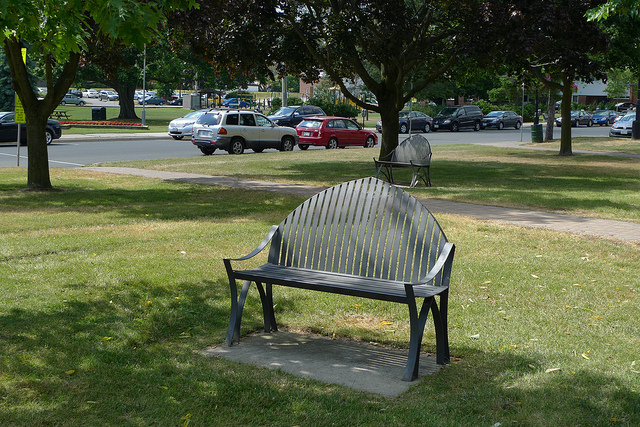

In [10]:
from PIL import Image

im = Image.open('/Users/ke/Documents/Cal/research/physical-reasoning/demo/demo.jpg')
im

In [7]:
m.pretrained_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth',
 'hf_hub_id': 'timm/tf_efficientnet_b0.ns_jft_in1k',
 'architecture': 'tf_efficientnet_b0',
 'tag': 'ns_jft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

In [13]:
data_cfg = timm.data.resolve_data_config(m.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [15]:
import torch


image_tensor = transform(im)
image_as_batch = image_tensor.unsqueeze(0)

output = m(image_as_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

values, indices = torch.topk(probabilities, 5)

In [16]:
import requests


IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': val.item()} for val, idx in zip(values, indices)]

[{'label': 'park_bench', 'value': 0.8876426219940186},
 {'label': 'ashcan, trash_can, garbage_can, wastebin, ash_bin, ash-bin, ashbin, dustbin, trash_barrel, trash_bin',
  'value': 0.0038169350009411573},
 {'label': 'folding_chair', 'value': 0.00252570235170424},
 {'label': 'patio, terrace', 'value': 0.0023707698564976454},
 {'label': 'rocking_chair, rocker', 'value': 0.0020109317265450954}]

Detected bench with confidence 0.959 at location [220.94, 176.79, 456.94, 382.45]
Detected car with confidence 0.943 at location [191.47, 109.54, 299.18, 155.42]
Detected car with confidence 0.935 at location [294.73, 115.77, 378.74, 149.93]
Detected car with confidence 0.926 at location [482.16, 110.46, 522.93, 130.11]
Detected car with confidence 0.92 at location [431.47, 104.98, 484.49, 132.21]


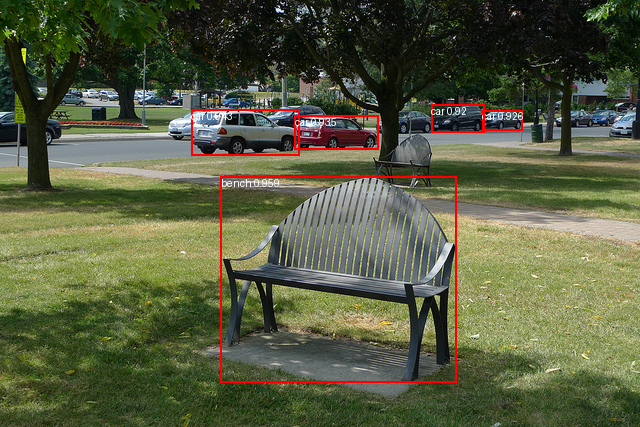

In [15]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from PIL import Image, ImageDraw
import requests
import torch

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = im.copy()

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101")
# image_processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
# model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd")
# RTDetrForObjectDetection - PekingU/rtdetr_r101vd is even worse than PekingU/rtdetr_r101vd_coco_o365
# 

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

logits = outputs.logits
list(logits.shape)

boxes = outputs.pred_boxes
list(boxes.shape)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

# show the image with bounding boxes using ImageDraw

image_draw = ImageDraw.Draw(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    image_draw.rectangle(box, outline="red", width=2)
    image_draw.text(box, f"{model.config.id2label[label.item()]} {round(score.item(), 3)}")

image
